# MPS using the deesse wrapper - inequality conditioning data


## Main points addressed:
- how to set and use inequality conditioning data

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=10, micro=9, releaselevel='final', serial=0)
geone version: 1.1.11


## Conditioning by inequalities

In addition to usual conditioning data (hard data), deesse handles conditioning data by inequalities. 

Inequality conditioning data can be given for a simulated variable by appending the suffix `_min` (resp. `_max`) to the variable name: the given values are then minimal (resp. maximal) bounds, i.e. indicating that, for this variable, the simulated values should be greater than or equal to (resp. less than or equal to) the given values.

Hence, one location in the simulation grid can be conditioned by a minimal value, a maximal value, or both minimal and maximal values.

Inequality conditioning data is generally used for continuous variables. However, such data is also handled for categorical variables: in this case, one can only indicate that the simulated category (discrete value) is within a contiguous range of categories. 

### Additional parameter: the maximal proportion of inequality data cells in a pattern
Any simulation grid cell with inequality data is informed and then will take a place in the pattern that will be searched in the TI during the simulation.

The parameter (keyword argument) `maxPropInequalityNode` specified in *DeesseInput* class is the maximal proportion of nodes (cells) with inequality data information in a pattern. This is a float number in $[0,1]$ (default value: $0.25$). 

During the simulation, a pattern retrieved from the simulation grid and having the maximal number of neighboring nodes will have, if possible, a proportion of nodes provided by inequality data information that does not exceed this specified parameter.

In presence of a dense inequality data set, the maximal proportion of nodes with inequality data information in a pattern (parameter `maxPropInequalityNode`) should be small, in order to retrieve patterns sufficiently wide and with enough nodes with a defined value (previously simulated or hard data) for a better reproduction of the spatial structure given in the TI (see example 2 below).

### Limitations
- Inequality data cannot be used for a variable simulated using the *relative distance* mode (see example in the jupyter notebook `ex_deesse_04_continuous_sim`). If deesse is launched with such specifications, the simulation will be *stopped* and an error retrieved.
- Inequality data cannot be used for a variable for which *connectivity data* is specified (see example in the jupyter notebook `ex_deesse_07_connectivity_data`). If deesse is launched with such specifications, the simulation will be done but the inequality data will be ignored (and a warning will be displayed).

## Example 1

### Training image (TI)
Read the TI and plot it. Source of the image: *T. Zhang, P. Switzer, and A. Journel, Filter-based classification of training image patterns for spatial simulation, MATHEMATICAL GEOLOGY, 38(1):63-80, JAN 2006,[ doi:10.1007/s11004-005-9004-x](https://dx.doi.org/10.1007/s11004-005-9004-x).*

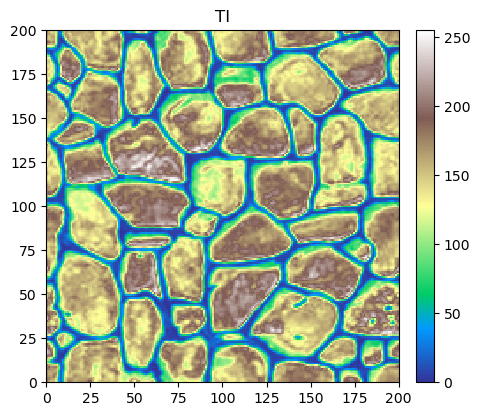

In [3]:
data_dir = 'data' # directory containing the training image file
ti = gn.img.readImageGslib(os.path.join(data_dir, 'tiContinuous.gslib'))

plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(ti, cmap='terrain', title='TI')
plt.show()

### Simulation grid
Define the simulation grid (number of cells in each direction, cell unit, origin).

In [4]:
nx, ny, nz = 200, 200, 1         # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

### Conditioning data
Define some conditioning data in a point set. Consider that the name of the simulated variable is 'code'. Here 4 conditioning locations are considered with a usual hard data value at the location of index 0 (variable: 'code'), a minimal value only (inequality data, variable: 'code_min') at the location of index 1, a maximal value only (inequality data, variable: 'code_max') at the location of index 2, and a minimal value and a maximal value (inequality data, variables: 'code_min' and 'code_max') at the location of index 3.

In [5]:
npt = 4  # number of points
nv = 6   # number of variables including x, y, z coordinates
varname = ['x', 'y', 'z', 'code', 'code_min', 'code_max'] # list of variable names
v = np.array([
    [ 65.5,  65.5, 0.5,     120, np.nan, np.nan], # loc. #0: x, y, z, code, code_min (undef.), code_max (undef.)
    [135.5,  65.5, 0.5,  np.nan,    175, np.nan], # loc. #1: x, y, z, code (undef.), code_min, code_max (undef.)
    [ 65.5, 135.5, 0.5,  np.nan, np.nan,     40], # loc. #2: x, y, z, code (undef.), code_min (undef.), code_max
    [135.5, 135.5, 0.5,  np.nan,     60,    160]  # loc. #3: x, y, z, code (undef.), code_min, code_max
    ]).T # variable values: (nv, npt)-array
cd = gn.img.PointSet(npt=npt, nv=nv, varname=varname, val=v)

### Fill the input structure for deesse and launch deesse
**Note:** the variable name in `deesse_input` class is varname=`'code'`, the variable name in `cd.varname` is: `'code'` for usual hard data, `'code_min'` for minimal value and `'code_max'` for maximal value.

*(Note that the default value ($0.25$) is used for the keyword argument `maxPropInequalityNode`)*

In [6]:
nreal = 20
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',     # consistent name for the simulated variable
    TI=ti,
    dataPointSet=cd,          # ... and the names used in the data point set
    distanceType='continuous',
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230411 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete
Elapsed time: 40 sec


### Retrieve the results
And store all the realizations in a single image (one variable per realization).

In [7]:
# Retrieve the realizations
sim = deesse_output['sim']

# Gather the nreal realizations into one image
all_sim = gn.img.gatherImages(sim) # all_sim is one image with nreal variables

### Do some statistics on the simulated values at conditioning locations

In [8]:
# Get conditioning values ...
cd_value     = cd.val[3]     # for usual conditioning values   (variable index 3 in point set 'cd')
cd_value_min = cd.val[4]     # for minimal conditioning values (variable index 4 in point set 'cd')
cd_value_max = cd.val[5]     # for maximal conditioning values (variable index 5 in point set 'cd')

# Get index of conditioning location in simulation grid...
cd_grid_index = [gn.img.pointToGridIndex(x, y, z,
                                         all_sim.sx, all_sim.sy, all_sim.sz, 
                                         all_sim.ox, all_sim.oy, all_sim.oz) 
                 for (x,y,z) in zip(cd.x(), cd.y(), cd.z())]
# .. and index of simulation grid cell along each direction
cd_ix = [ind[0] for ind in cd_grid_index]
cd_iy = [ind[1] for ind in cd_grid_index]
cd_iz = [ind[2] for ind in cd_grid_index]

# Get simulated values at conditioning locations
sim_value_at_cd_loc = [all_sim.val[:, cd_iz[j], cd_iy[j], cd_ix[j]] for j in range(cd.npt)]
# sim_value_at_cd_loc: list of 4(=cd.npt) np.array of length 20(=nreal)

### Do some statistics on the realizations (whole map, pixel-wise mean and standard deviation)

In [9]:
# Do statistics over all the realizations: compute the pixel-wise mean and standard deviation
sim_mean = gn.img.imageContStat(all_sim, 'mean') # do statistics (pixel-wise mean)
sim_std = gn.img.imageContStat(all_sim, 'std')   # do statistics (pixel-wise standard deviation)

### Display results
Plot in a figure: the TI, the mean and standard deviation of the realizations, two of them, and the box-plots of the simulated value at the conditioning locations.

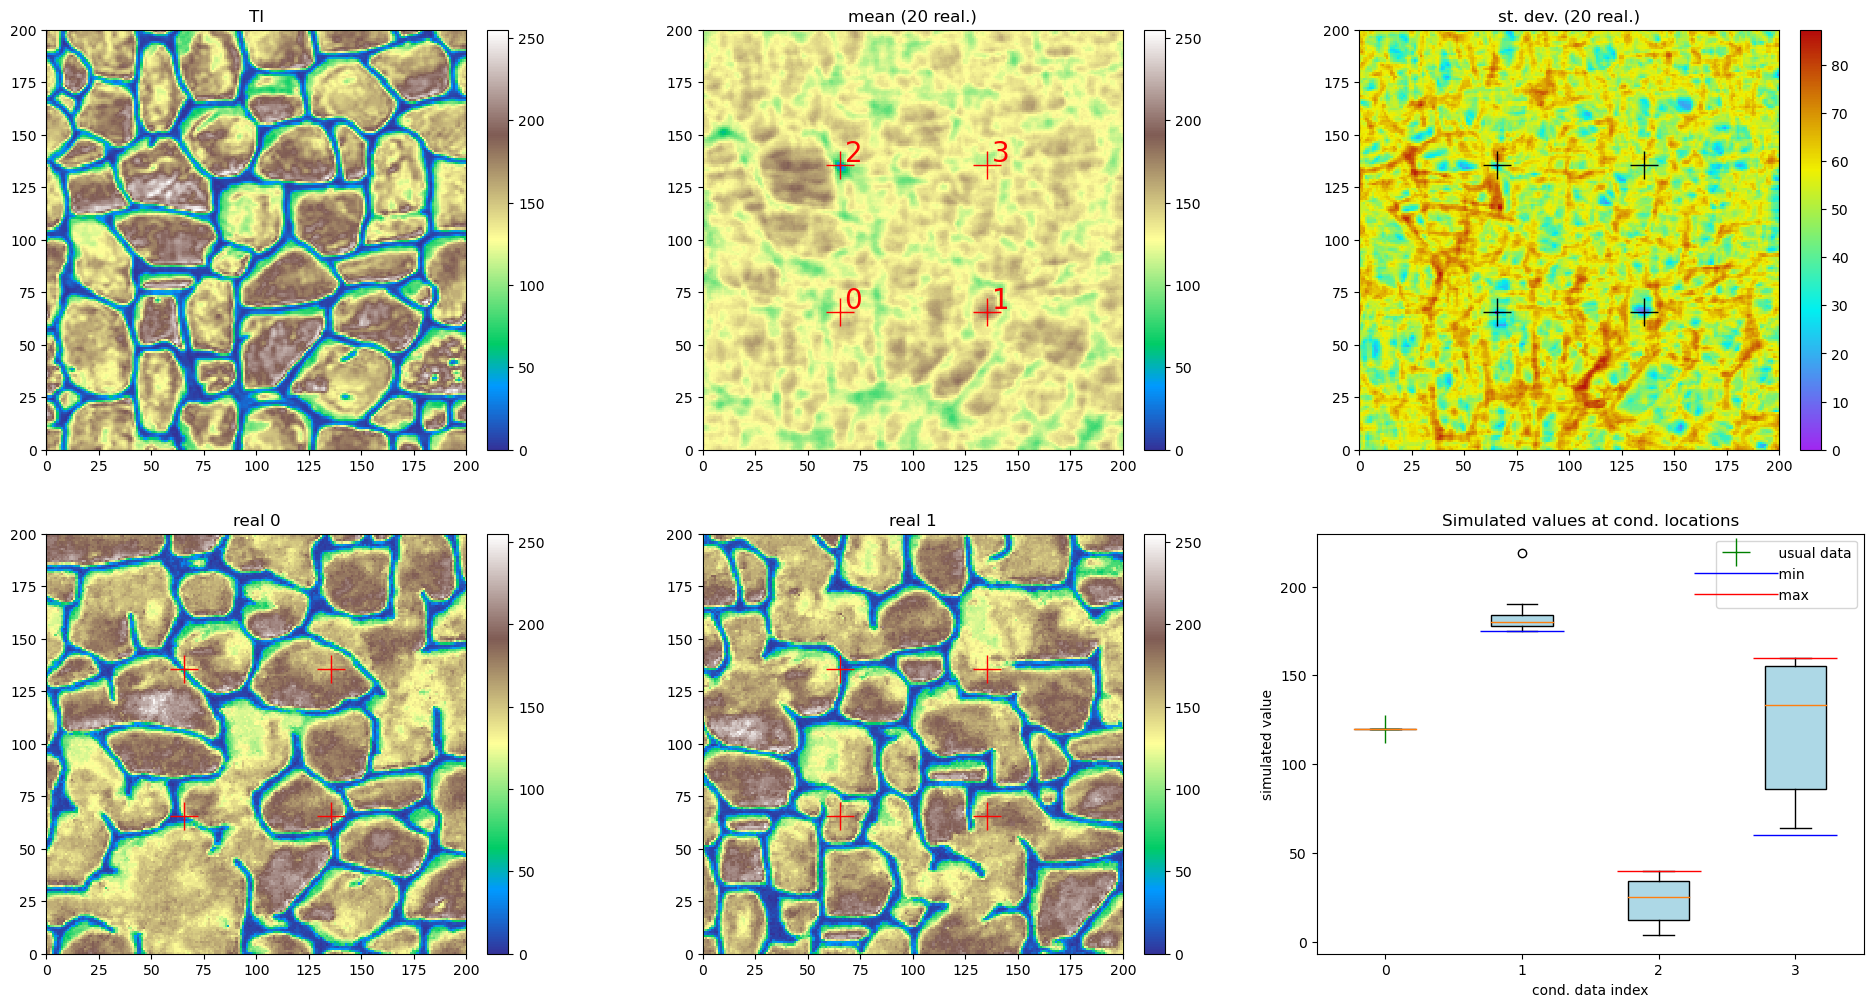

In [10]:
# Display

cmap = 'terrain' # color map for TI, realizations, and mean of the realizations
ti_vmin, ti_vmax = ti.vmin()[0], ti.vmax()[0]

# figure ...
fig, ax = plt.subplots(2, 3, figsize=(24, 12))

# plot TI
plt.sca(ax[0, 0])
gn.imgplot.drawImage2D(ti, cmap=cmap, vmin=ti_vmin, vmax=ti_vmax, title='TI')

# plot mean of realizations
plt.sca(ax[0, 1])
gn.imgplot.drawImage2D(sim_mean, cmap=cmap, vmin=ti_vmin, vmax=ti_vmax, title=f'mean ({nreal} real.)')
plt.plot(cd.x(), cd.y(), '+', markersize=20, c='red') # add conditioning data points
for j in range(cd.npt):
    plt.text(cd.x()[j]+2, cd.y()[j]+2, f'{j}', size=20, color='red') # add conditioning data point index

# plot standard deviation of realizations
plt.sca(ax[0, 2])
gn.imgplot.drawImage2D(sim_std, title=f'st. dev. ({nreal} real.)')
plt.plot(cd.x(), cd.y(), '+', markersize=20, c='black') # add conditioning data points

# plot two realizations
for i in [0, 1]:
    # plot real #i
    plt.sca(ax[1, i])
    gn.imgplot.drawImage2D(all_sim, iv=i, cmap=cmap, vmin=ti_vmin, vmax=ti_vmax, title=f'real {i}')
    plt.plot(cd.x(), cd.y(), '+', markersize=20, c='red') # add conditioning data points


# box-plot of simulated value at conditioning location
plt.sca(ax[1, 2])
bplot = plt.boxplot(sim_value_at_cd_loc, labels=np.arange(cd.npt), patch_artist=True)
for p in bplot['boxes']:
    p.set_facecolor('lightblue') # fill box plot with color

plt.plot(1+np.arange(cd.npt), cd_value,     lw=3, marker='+', ms=20, ls='none', c='green', label='    usual data')
plt.plot(1+np.arange(cd.npt), cd_value_min, lw=3, marker='_', ms=60, ls='none', c='blue' , label='    min')
plt.plot(1+np.arange(cd.npt), cd_value_max, lw=3, marker='_', ms=60, ls='none', c='red'  , label='    max')
plt.legend()
plt.xlabel('cond. data index')
plt.ylabel('simulated value')
plt.title('Simulated values at cond. locations')

plt.show()

## Example 2 - Simulation with dense inequality data set
In this example, the same TI as in example above is used, and maximal values (inequality data) are given everywhere in the simulation grid. A brief illustration of the sensitivity to the parameter `maxPropInequalityNode` ($p_{ineq}$) is proposed below.

### Inequality data: maximal values
Using the same TI as above, a set of maximal values (inequality data) is defined as a (shifted) unconditional simulation.

In [11]:
# Unconditional simulation
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    TI=ti,
    distanceType=1,
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=777,
    nrealization=1)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

# Set inequality data: maximal values
im_max = deesse_output['sim'][0]
im_max.varname[0] = 'code_max'
im_max.val = np.minimum(im_max.val + 20, ti_vmax)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230411 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete
Elapsed time: 2.5 sec


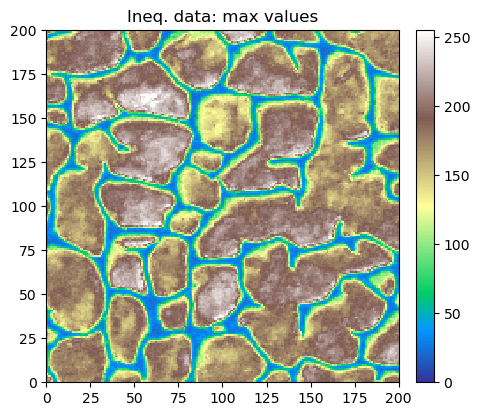

In [12]:
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(im_max, cmap=cmap, vmin=ti_vmin, vmax=ti_vmax, title='Ineq. data: max values')
plt.show()

### Simulations: sensitivity to the parameter $p_{ineq}$

Simul. with p_ineq = 0.00
DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230411 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete
Simul. with p_ineq = 0.10
DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230411 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete
Simul. with p_ineq = 0.20
DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230411 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete
Simul. with p_ineq = 0.30
DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230411 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete
Simul. with p_ineq = 0.40
DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230411 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete
Simul. with p_ineq = 0.50
DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230411 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete
Simul. with p_ineq = 0.60
DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230411 / OpenMP 19 t

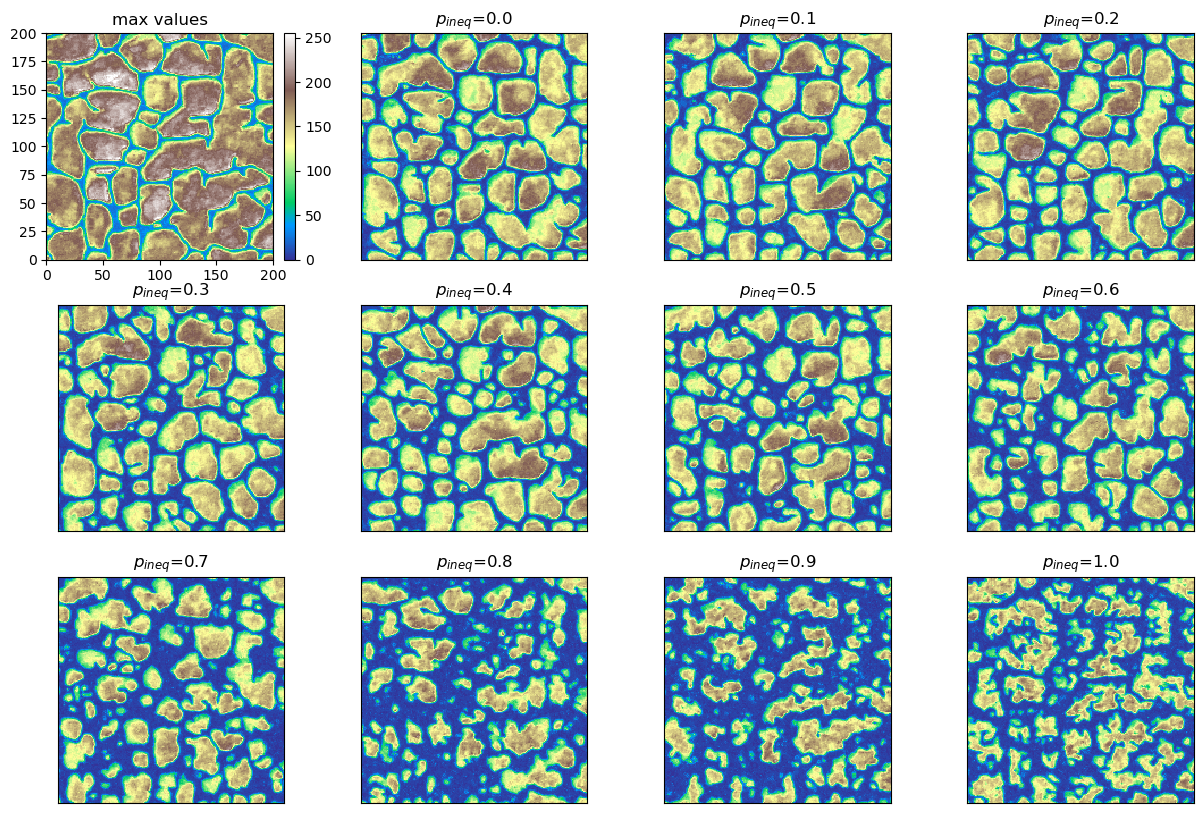

In [13]:
# Test different value for maximal proportion of inequality data in pattern (p_ineq)
p_ineq = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]

t1 = time.time() # start time

sim=[]
for p in p_ineq:
    deesse_input = gn.deesseinterface.DeesseInput(
        nx=nx, ny=ny, nz=nz,
        sx=sx, sy=sy, sz=sz,
        ox=ox, oy=oy, oz=oz,
        nv=1, varname='code',
        TI=ti,
        dataImage=im_max,          # conditioning data (image)
        distanceType=1,
        nneighboringNode=24,
        distanceThreshold=0.02,
        maxScanFraction=0.25,
        maxPropInequalityNode=p,   # maximal proportion of inequality data in pattern
        npostProcessingPathMax=1,
        seed=444,
        nrealization=1)
    print(f'Simul. with p_ineq = {p:3.2f}')
    deesse_output = gn.deesseinterface.deesseRun(deesse_input)
    sim.append(deesse_output['sim'][0])
    
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

# figure ...
fig, ax = plt.subplots(3,4, figsize=(15,10))

plt.subplot(3,4,1)
gn.imgplot.drawImage2D(im_max, cmap=cmap, vmin=ti_vmin, vmax=ti_vmax, title='max values')

for i in range(len(p_ineq)):
    plt.subplot(3,4,i+2)
    gn.imgplot.drawImage2D(sim[i], cmap=cmap, vmin=ti_vmin, vmax=ti_vmax, 
                           xaxis=False, yaxis=False, showColorbar=False,
                           title='$p_{ineq}$=' + f'{p_ineq[i]}')

plt.show()